In [1]:
import os
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import sys
sys.path.append('/home/yuanyuan.fu/bin/scripts') 
import plot_spatial_histograms as histplot
from scalebar_util import add_scalebar
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42

root_directory = '/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/BasalGanglia_paper_package/data/human/ATAC/Astro_subGroup/spatial/fig5'
os.chdir(root_directory)


/home/yuanyuan.fu/bin/miniconda3/envs/iterative_scANVI_May9/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/yuanyuan.fu/bin/miniconda3/envs/iterative_scANVI_May9/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/yuanyuan.fu/bin/miniconda3/envs/iterative_scANVI_May9/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/yuanyuan.fu/bin/miniconda3/envs/iterative_scANVI_May9/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/

### to show the structure

In [3]:
region_cols = ['STR', 'GPe', 'GPi', 'VP', 'SN', 'STH']

# Create the new 'anatomical_structure' column
def assign_region(row):
    for region in region_cols:
        if row[region]:
            return region
    return 'adjacent'

adata_human.obs['anatomical_structure'] = adata_human.obs.apply(assign_region, axis=1)
adata_human.obs['anatomical_structure'].value_counts()

anatomical_structure
STR         3322914
adjacent    3065314
GPe          342864
SN            90966
GPi           89045
VP            43161
STH           37864
Name: count, dtype: int64

In [4]:
adata_human_structure = adata_human[adata_human.obs['qc_pass']].copy() 

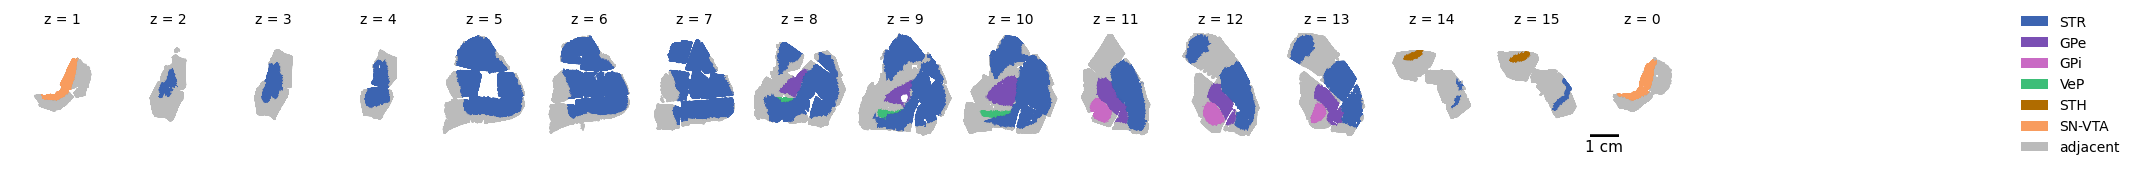

In [6]:
from matplotlib.patches import Patch

# Region mapping
anatomical_to_color_key = {
    'STR': 'STR',
    'GPe': 'GPe',
    'GPi': 'GPi',
    'VP': 'VeP',
    'SN': 'SN-VTA',
    'STH': 'STH',
    'adjacent': 'adjacent'
}
region_color_map = {
    "STR": "#3C64B1", 
    "GPe": "#7A4FB4", 
    "GPi": "#C96AC4",
    "SN-VTA": "#F89C5E", 
    "STH": "#B06C00",
    "VeP": "#3DBE78", 
    "adjacent": "#BBBBBB"
}
ordered_color_keys = ['STR', 'GPe', 'GPi', 'VeP', 'STH', 'SN-VTA', 'adjacent']
#selected_sections = [3, 6, 9, 12, 15, 0]
selected_sections = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 0]

# Define fixed spatial canvas size (in µm)
plot_size_um = 300 * 120  # 36000 µm
half_size = plot_size_um / 2

# Create subplots
fig, axes = plt.subplots(1, len(selected_sections), figsize=(20, 3), sharex=True, sharey=True)
if len(selected_sections) == 1:
    axes = [axes]

for ax, z in zip(axes, selected_sections):
    adata_subset = adata_human_structure[adata_human_structure.obs['z_order'] == z].copy()

    # Assign region colors
    adata_subset.obs['region_color_key'] = adata_subset.obs['anatomical_structure'].map(anatomical_to_color_key)
    adata_subset.obs['region_color_key'] = pd.Categorical(
        adata_subset.obs['region_color_key'],
        categories=ordered_color_keys,
        ordered=True
    )

    # Get spatial coordinates
    coords = adata_subset.obsm['spatial_grid']
    colors = adata_subset.obs['region_color_key'].map(region_color_map)

    # Compute bounding box center for consistent alignment
    x_min, x_max = coords[:, 0].min(), coords[:, 0].max()
    y_min, y_max = coords[:, 1].min(), coords[:, 1].max()
    center_x = (x_min + x_max) / 2
    center_y = (y_min + y_max) / 2
    center = np.array([center_x, center_y])

    # Shift to center of fixed-size canvas
    shifted_coords = coords - center + half_size

    # Plot
    ax.scatter(
        shifted_coords[:, 0],
        shifted_coords[:, 1],
        c=colors,
        s=1,
        linewidth=0,
        rasterized=True
    )
    ax.set_xlim(0, plot_size_um)
    ax.set_ylim(0, plot_size_um)
    ax.set_title(f'z = {z}', fontsize=10)
    ax.set_aspect('equal')
    ax.axis('off')

# Legend
legend_elements = [Patch(facecolor=region_color_map[k], label=k) for k in ordered_color_keys]
fig.legend(
    handles=legend_elements,
    loc='center left',
    bbox_to_anchor=(1.01, 0.5),
    borderaxespad=0,
    frameon=False
)

# Add scalebar
add_scalebar(
    axes[-1],
    matchx=False,
    matchy=False,
    hidex=True,
    hidey=True,
    loc='lower middle',
    fontsize=11,
    barcolor='black',
    barwidth=4,
    offset=(0.0, 0.0),
    sizex=10000,
    labelx='1 cm'
)

# Save and display
output_dir = root_directory + '/results/figures_astro_enrichment'
os.makedirs(output_dir, exist_ok=True)

fig.savefig(
    f"{output_dir}/anatomical_structure_onlyATLASreleaseplot.pdf",
    dpi=300,
    bbox_inches='tight'
)

plt.tight_layout()
plt.subplots_adjust(wspace=0.0, right=0.85)
plt.show()


### Marmoset

In [2]:
marmoset = sc.read_h5ad(root_directory + "/../Xenium-CJ23.56.004-annotated20250402-mmcMappedClusterV3-20250617_subcortex_all_cells.h5ad")
marmoset

AnnData object with n_obs × n_vars = 5580065 × 300
    obs: 'brain_section_barcode', 'brain_section_label', 'x', 'y', 'xenium_filename', 'total_counts', 'total_counts_genes', 'total_counts_control_probe', 'total_counts_genomic_control', 'total_counts_control_codeword', 'total_counts_unassigned_codeword', 'total_counts_deprecated_codeword', 'cell_area', 'nucleus_area', 'n_nuclei_in_cell', 'segmentation_method', 'qc_pass', 'cluster_id', 'cluster_id_mmc_bootstrapping_probability', 'cluster_id_mmc_aggregate_probability', 'cluster_id_mmc_avg_correlation', 'Neighborhood', 'Class', 'Subclass', 'Group', 'Cluster', 'Siletti_human_Supercluster', 'ABC_mouse_Class', 'ABC_mouse_Subclass', 'ABC_mouse_Cluster', 'basal_ganglia_and_adjacent', 'STR', 'GP', 'GPe', 'GPi', 'SN', 'STH', 'VP', 'z_order', 'segmentation_job_id', 'x_rotated', 'y_rotated', 'abc_atlas_release', 'abc_atlas_visualization'
    uns: 'Class_colors', 'Group_colors', 'Neighborhood_colors', 'Subclass_colors', 'log1p'
    obsm: 'spatial_g

In [3]:
selected_sections = [13] #12, 16

marmoset_str = marmoset[
    (marmoset.obs['z_order'].isin(selected_sections)) &
    (marmoset.obs['qc_pass'])  & 
    (marmoset.obs['abc_atlas_release'])
    ].copy()

marmoset_str

AnnData object with n_obs × n_vars = 53229 × 300
    obs: 'brain_section_barcode', 'brain_section_label', 'x', 'y', 'xenium_filename', 'total_counts', 'total_counts_genes', 'total_counts_control_probe', 'total_counts_genomic_control', 'total_counts_control_codeword', 'total_counts_unassigned_codeword', 'total_counts_deprecated_codeword', 'cell_area', 'nucleus_area', 'n_nuclei_in_cell', 'segmentation_method', 'qc_pass', 'cluster_id', 'cluster_id_mmc_bootstrapping_probability', 'cluster_id_mmc_aggregate_probability', 'cluster_id_mmc_avg_correlation', 'Neighborhood', 'Class', 'Subclass', 'Group', 'Cluster', 'Siletti_human_Supercluster', 'ABC_mouse_Class', 'ABC_mouse_Subclass', 'ABC_mouse_Cluster', 'basal_ganglia_and_adjacent', 'STR', 'GP', 'GPe', 'GPi', 'SN', 'STH', 'VP', 'z_order', 'segmentation_job_id', 'x_rotated', 'y_rotated', 'abc_atlas_release', 'abc_atlas_visualization'
    uns: 'Class_colors', 'Group_colors', 'Neighborhood_colors', 'Subclass_colors', 'log1p'
    obsm: 'spatial_gri

#### NTN1 in astro

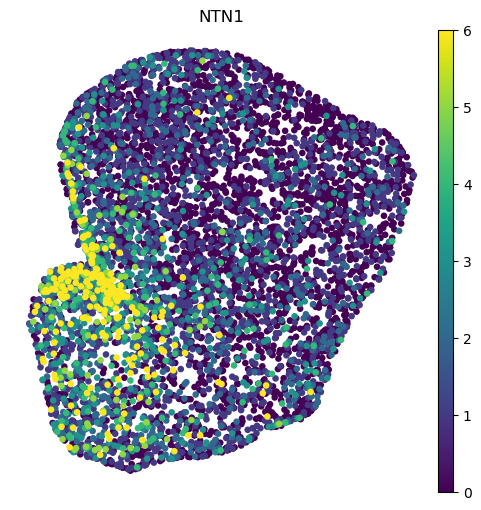

In [7]:
marmoset_astro = marmoset_str[
    marmoset_str.obs['Group'] == 'Astrocyte'  #    #(marmoset_str.obs['Cluster'] == 'Marmoset-670') & #homologous of human-7
]

with plt.rc_context({"figure.figsize": (6, 6)}):
    sc.pl.embedding(
        marmoset_astro,
        use_raw=False,
        layer='raw',
        basis="spatial_grid",
        color=['NTN1'],
        frameon=False,
        ncols=1,
        vmin='p2',
        vmax='p98',
        size=90,
        save="NTN1_in_Marmoset_Astro.pdf"
    )

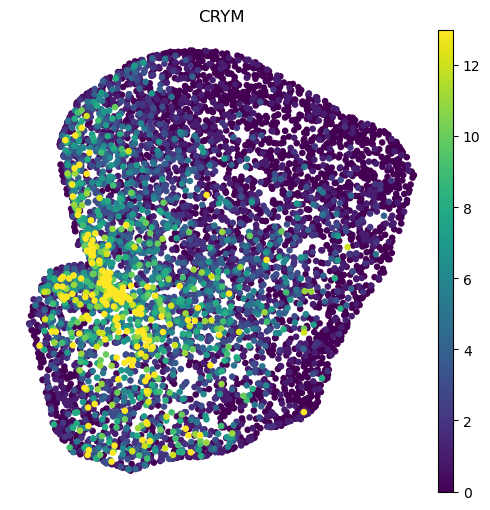

In [8]:
marmoset_astro = marmoset_str[
    marmoset_str.obs['Group'] == 'Astrocyte'  #    #(marmoset_str.obs['Cluster'] == 'Marmoset-670') & #homologous of human-7
]

with plt.rc_context({"figure.figsize": (6, 6)}):
    sc.pl.embedding(
        marmoset_astro,
        use_raw=False,
        layer='raw',
        basis="spatial_grid",
        color=['CRYM'],
        frameon=False,
        ncols=1,
        vmin='p2',
        vmax='p98',
        size=90,
        save="CRYM_in_Marmoset_Astro.pdf"
    )

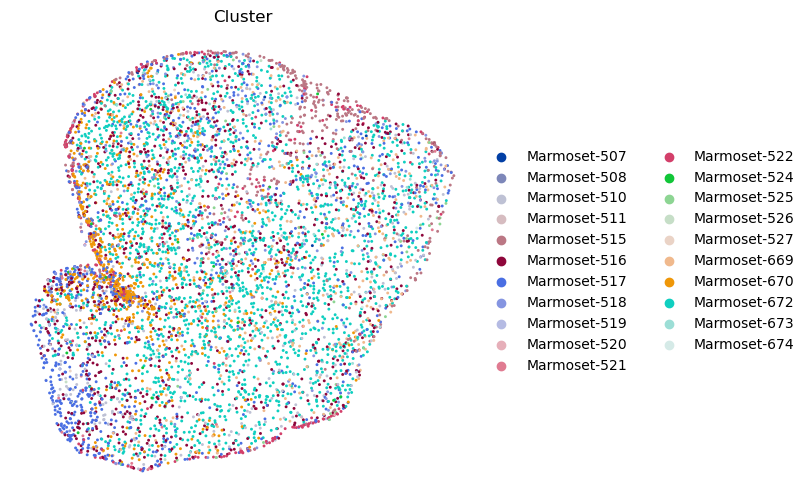

In [10]:
with plt.rc_context({"figure.figsize": (6, 6)}):
    sc.pl.embedding(
        marmoset_astro,
        use_raw=False,
        layer='raw',
        basis="spatial_grid",
        color=['Cluster'],
        frameon=False,
        ncols=1,
        #size=90,
        save="Clusters_in_Marmoset_Astro.pdf"
    )

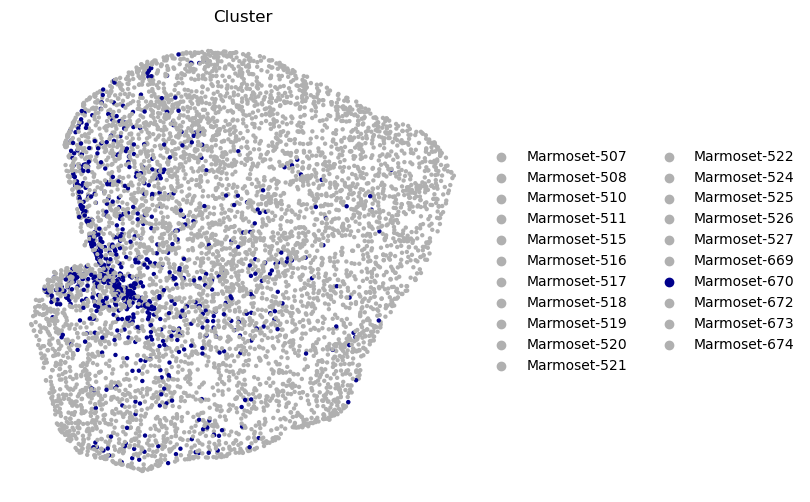

In [14]:
marmoset_astro.obs['Cluster'] = marmoset_astro.obs['Cluster'].cat.remove_unused_categories()

cats = marmoset_astro.obs['Cluster'].cat.categories
cats_list = list(cats)


palette = np.full(len(cats_list), '#B0B0B0', dtype=object)  # '#C0C0C0'


try:
    idx_670 = cats_list.index('Marmoset-670')
    palette[idx_670] = '#00008B' 
except ValueError:
    print("⚠️ 'Marmoset-670' not in categories：", cats_list)


marmoset_astro.uns['Cluster_colors'] = palette.tolist()

with plt.rc_context({"figure.figsize": (6, 6)}):
    sc.pl.embedding(
        marmoset_astro,
        use_raw=False,
        layer='raw',
        basis="spatial_grid",
        color=['Cluster'],
        frameon=False,
        ncols=1,
        size=40,
        save="Clusters_in_Marmoset_Astro_670blue.pdf"
    )


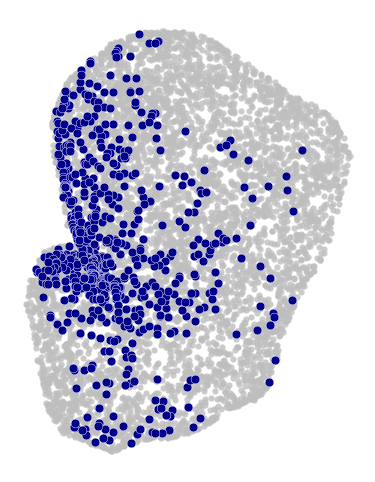

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc

# Ensure category order & remove unused
marmoset_astro.obs['Cluster'] = marmoset_astro.obs['Cluster'].cat.remove_unused_categories()

# Prepare masks
is_670 = marmoset_astro.obs['Cluster'] == 'Marmoset-670'
is_other = ~is_670

# Coordinates
coords = marmoset_astro.obsm['spatial_grid']

# Colors
color_670 = '#00008B'
color_other = '#BEBEBE'

with plt.rc_context({"figure.figsize": (8, 6)}):
    fig, ax = plt.subplots()

    # --- 1) plot gray points first ---
    ax.scatter(
        coords[is_other, 0],
        coords[is_other, 1],
        s=20,                 # small gray points
        c=color_other,
        linewidths=0,
        alpha=0.8
    )

    # --- 2) plot blue points on top ---
    ax.scatter(
        coords[is_670, 0],
        coords[is_670, 1],
        s=40,                # larger blue points
        c=color_670,
        linewidths=0.3,
        edgecolors="white",   # optional, to make blue points pop
        alpha=1.0,
        zorder=10              # force on top
    )

    ax.set_aspect('equal')
    ax.axis("off")

    plt.savefig("Clusters_in_Marmoset_Astro_670blue.pdf", dpi=300, bbox_inches="tight")
    plt.show()


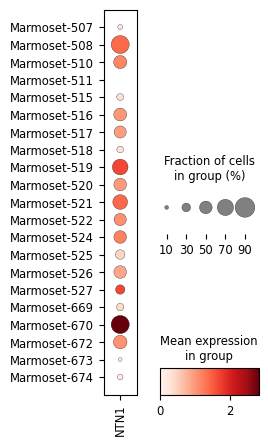

In [218]:
sc.pl.dotplot(marmoset_astro, 
              ['NTN1'], 
              groupby='Cluster', 
              standard_scale=None,#'var',
              use_raw=False, 
              layer='raw',
              swap_axes=False, 
              figsize=(2,5),
              save="dotplot_NTN1_in_MarmosetSpatialTx_Astro_Clusters.pdf" 
) 

#### TAC3 in msn

In [18]:
set(marmoset_str.obs['Group'])

{'AMY-SLEA-BNST GABA',
 'Adjacent',
 'Astrocyte',
 'BAM',
 'BF SKOR1 Glut',
 'COP',
 'Endo',
 'Ependymal',
 'GPe MEIS2-SOX6 GABA',
 'GPe SOX6-CTXND1 GABA',
 'GPe-NDB-SI LHX6-LHX8-GBX1 GABA',
 'GPin-BF Cholinergic GABA',
 'ImOligo',
 'LAMP5-CXCL14 GABA',
 'LAMP5-LHX6 GABA',
 'Microglia',
 'OB Dopa-GABA',
 'OB FRMD7 GABA',
 'OPC',
 'OT D1 ICj',
 'Oligo OPALIN',
 'Oligo PLEKHG1',
 'Pericyte',
 'SMC',
 'SN EBF2 GABA',
 'SN GATA3-PAX8 GABA',
 'SN SEMA5A GABA',
 'SN-VTR-HTH GATA3-TCF7L2 GABA',
 'STR Cholinergic GABA',
 'STR D1D2 Hybrid MSN',
 'STR FS PTHLH-PVALB GABA',
 'STR LYPD6-RSPO2 GABA',
 'STR SST-ADARB2 GABA',
 'STR SST-CHODL GABA',
 'STR SST-RSPO2 GABA',
 'STR TAC3-PLPP4 GABA',
 'STR-BF TAC3-PLPP4-LHX8 GABA',
 'STRd Cholinergic GABA',
 'STRd D1 Matrix MSN',
 'STRd D1 Striosome MSN',
 'STRd D2 Matrix MSN',
 'STRd D2 StrioMat Hybrid MSN',
 'STRd D2 Striosome MSN',
 'STRv D1 MSN',
 'STRv D1 NUDAP MSN',
 'STRv D2 MSN',
 'VIP GABA',
 'VLMC',
 'VTR-HTH Glut',
 'ZI-HTH GABA'}

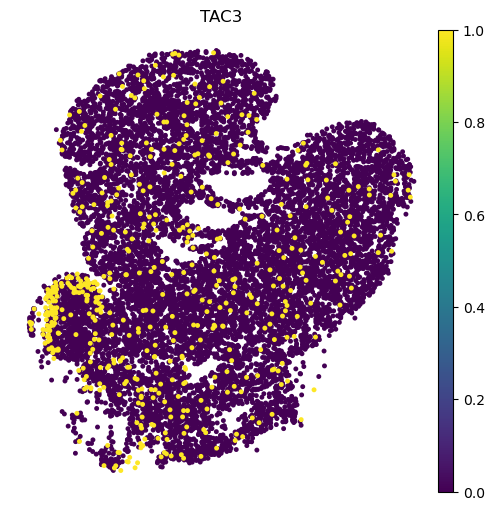

In [28]:
marmoset_tac3msn = marmoset_str[
    marmoset_str.obs['Group'].isin(['STRv D1 MSN', 'STRd D1 Matrix MSN', 'STRd D1 Striosome MSN']) #, 'STRv D1 NUDAP MSN'
]


with plt.rc_context({"figure.figsize": (6, 6)}):
    sc.pl.embedding(
        marmoset_tac3msn,
        use_raw=False,
        layer='raw',
        basis="spatial_grid",
        color=['TAC3'],
        frameon=False,
        ncols=1,
        vmin='p2',
        vmax='p98',
        size=50,
        save="TAC3_in_Marmoset_D1MSNsubclass.pdf"
    )

In [31]:
marmoset_tac3msn = marmoset_str[
    marmoset_str.obs['Group'].isin(['STRd D2 StrioMat Hybrid MSN']) #, 'STRv D1 NUDAP MSN'
]


with plt.rc_context({"figure.figsize": (6, 6)}):
    sc.pl.embedding(
        marmoset_tac3msn,
        use_raw=False,
        layer='raw',
        basis="spatial_grid",
        color=['HTR7'],
        frameon=False,
        ncols=1,
        vmin='p2',
        vmax='p98',
        size=50,
        save="HTR7_in_Marmoset_D2StrioMat.pdf"
    )

KeyError: 'Could not find key HTR7 in .var_names or .obs.columns.'

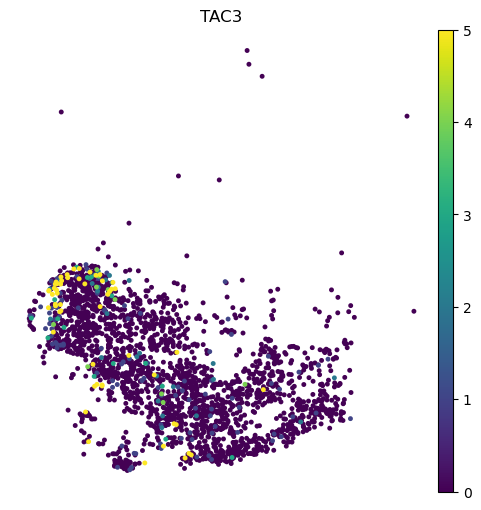

In [4]:
marmoset_tac3msn = marmoset_str[
    marmoset_str.obs['Group'].isin(['STRv D1 MSN']) #, 'STRd D1 Matrix MSN', 'STRd D1 Matrix Striosome'
]


with plt.rc_context({"figure.figsize": (6, 6)}):
    sc.pl.embedding(
        marmoset_tac3msn,
        use_raw=False,
        layer='raw',
        basis="spatial_grid",
        color=['TAC3'],
        frameon=False,
        ncols=1,
        vmin='p2',
        vmax='p98',
        save="TAC3_in_Marmoset_D1STRvMSN.pdf"
    )

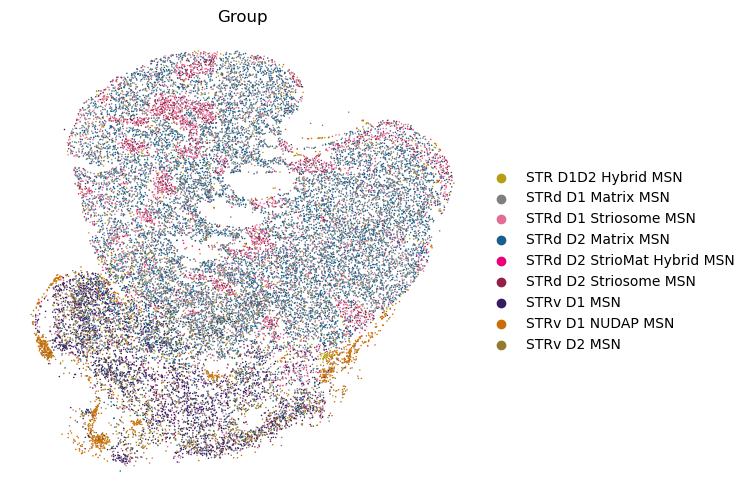

In [7]:
marmoset_str.obs['Group'] = marmoset_str.obs['Group'].astype(str)

target_groups = [
    "STRd D1 Matrix MSN",
    "STRd D1 Striosome MSN",
    "STRd D2 Matrix MSN",
    "STRd D2 StrioMat Hybrid MSN",
    "STRd D2 Striosome MSN",
    "STRv D1 MSN",
    "STRv D2 MSN",
    "STRv D1 NUDAP MSN",
    "STR D1D2 Hybrid MSN",
   # "OT D1 ICj"
]

mask = marmoset_str.obs['Group'].isin(target_groups)
marmoset_msn = marmoset_str[mask].copy()


with plt.rc_context({"figure.figsize": (6, 6)}):
    sc.pl.embedding(
        marmoset_msn,
        use_raw=False,
        layer='raw',
        basis="spatial_grid",
        color=['Group'],
        frameon=False,
        ncols=1,
       # save="Markers_neurotransmitter_fig2_subGroup.png"
    )

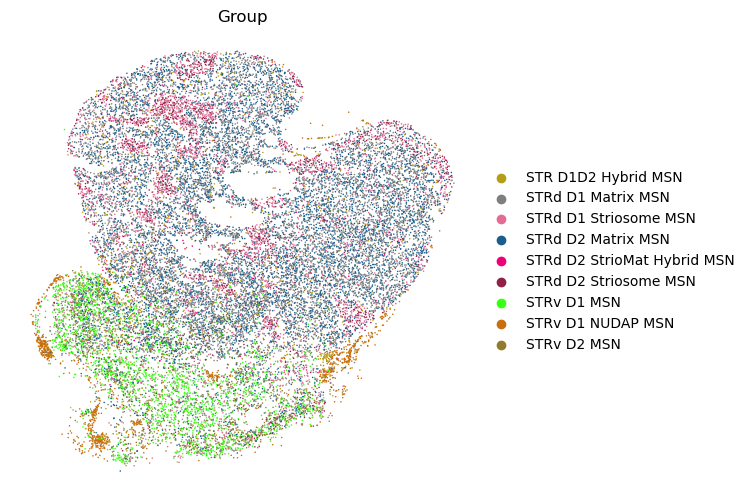

In [151]:
idx = list(cats).index("STRv D1 MSN")
colors = marmoset_msn.uns['Group_colors'].copy()
colors[idx] = '#39FF14'
marmoset_msn.uns['Group_colors'] = colors


with plt.rc_context({"figure.figsize": (6, 6)}):
    sc.pl.embedding(
        marmoset_msn,
        use_raw=False,
        layer='raw',
        basis="spatial_grid",
        color=['Group'],
        frameon=False,
        ncols=1,
        save="Group_in_Marmoset_MSNs.pdf"
    )

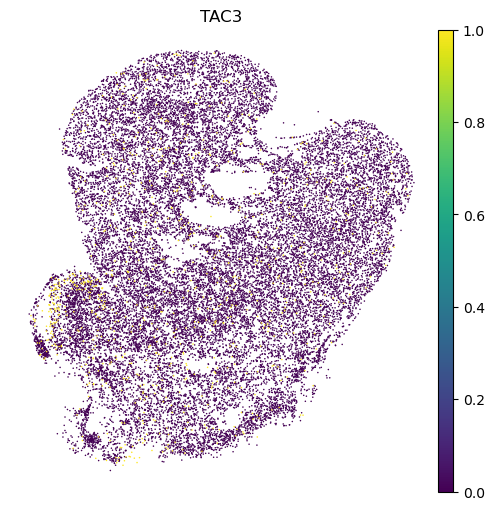

In [6]:
with plt.rc_context({"figure.figsize": (6, 6)}):
    sc.pl.embedding(
        marmoset_msn,
        use_raw=False,
        layer='raw',
        basis="spatial_grid",
        color=['TAC3'],
        frameon=False,
        ncols=1,
        vmin='p2',
        vmax='p98',
        save="TAC3_in_Marmoset_MSN.pdf"
    )

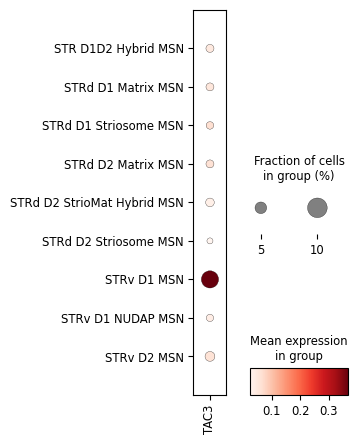

In [7]:
sc.pl.dotplot(marmoset_msn, 
              ['TAC3'], 
              groupby='Group', 
              standard_scale=None,#'var',
              use_raw=False, 
              layer='raw',
              swap_axes=False, 
              figsize=(2,5),
              save="dotplot_TAC3_in_MarmosetSpatialTx_MSNs_Groups.pdf" 
) 

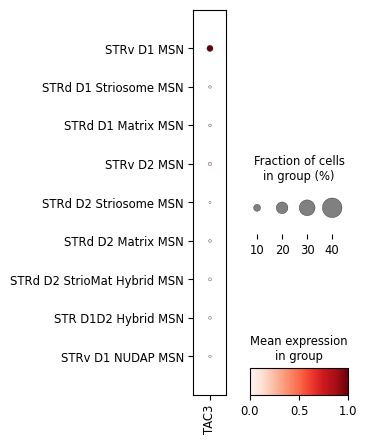

In [26]:
group_order = ['STRv D1 MSN', 'STRd D1 Striosome MSN', 'STRd D1 Matrix MSN', 'STRv D2 MSN', 'STRd D2 Striosome MSN', 'STRd D2 Matrix MSN', 'STRd D2 StrioMat Hybrid MSN', 'STR D1D2 Hybrid MSN', 'STRv D1 NUDAP MSN']
marmoset_msn.obs['Group'] = pd.Categorical(marmoset_msn.obs['Group'],
                                          categories=group_order,
                                          ordered=True)

sc.pl.dotplot(marmoset_msn, 
              ['TAC3'], 
              groupby='Group', 
              standard_scale='var',#'var',
              use_raw=False, 
              layer='raw',
              swap_axes=False, 
              figsize=(2,5),
              dot_max=0.4,
              save="dotplot_TAC3_in_MarmosetSpatialTx_MSNs_Groups_scaled.pdf" 
) 

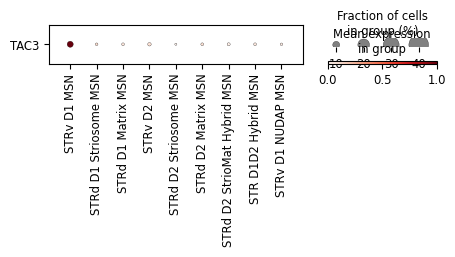

In [12]:
group_order = ['STRv D1 MSN', 'STRd D1 Striosome MSN', 'STRd D1 Matrix MSN', 'STRv D2 MSN', 'STRd D2 Striosome MSN', 'STRd D2 Matrix MSN', 'STRd D2 StrioMat Hybrid MSN', 'STR D1D2 Hybrid MSN', 'STRv D1 NUDAP MSN']
marmoset_msn.obs['Group'] = pd.Categorical(marmoset_msn.obs['Group'],
                                          categories=group_order,
                                          ordered=True)

sc.pl.dotplot(marmoset_msn, 
              ['TAC3'], 
              groupby='Group', 
              standard_scale='var',#'var',
              use_raw=False, 
              layer='raw',
              swap_axes=True, 
              figsize=(5,0.5),
              dot_max=0.4,
              save="dotplot_TAC3_in_MarmosetSpatialTx_MSNs_Groups_scaled2.pdf" 
) 

### Macaque

In [24]:
macaque = sc.read_h5ad(root_directory + "/../hmba_release_format_macaque_cirro_h5ad_20250624.h5ad")
macaque

AnnData object with n_obs × n_vars = 7901286 × 315
    obs: 'x', 'y', 'brain_section_label', 'brain_section_barcode', 'slab', 'block', 'set', 'z_order', 'total_counts', 'total_counts_genes', 'n_genes_by_counts', 'total_counts_Blank', 'pct_counts_Blank', 'genes_filter', 'counts_filter', 'blanks_filter', 'qc_pass', 'incongruous_pairs_pct', 'incongruous_genes_pct', 'doublets_filter', 'qc_pass_and_singlet', 'doublet_singlet_score_diff', 'doublet_diff_threshold', 'hierarchy_consistent', 'Neighborhood', 'Neighborhood_bootstrapping_probability', 'Neighborhood_correlation_coefficient', 'Class', 'Class_bootstrapping_probability', 'Class_correlation_coefficient', 'Subclass', 'Subclass_bootstrapping_probability', 'Subclass_correlation_coefficient', 'Group', 'Group_bootstrapping_probability', 'Group_correlation_coefficient', 'cluster_id', 'cluster_id_bootstrapping_probability', 'cluster_id_correlation_coefficient', 'Neighborhood_entropy', 'Class_entropy', 'Subclass_entropy', 'Group_entropy', 'clus

In [25]:
selected_sections = [8] #6,7, 8

macaque_str = macaque[
    (macaque.obs['z_order'].isin(selected_sections)) &
    (macaque.obs['qc_pass'])  & 
    (macaque.obs['abc_atlas_release'])
    ].copy()

macaque_str

AnnData object with n_obs × n_vars = 198336 × 315
    obs: 'x', 'y', 'brain_section_label', 'brain_section_barcode', 'slab', 'block', 'set', 'z_order', 'total_counts', 'total_counts_genes', 'n_genes_by_counts', 'total_counts_Blank', 'pct_counts_Blank', 'genes_filter', 'counts_filter', 'blanks_filter', 'qc_pass', 'incongruous_pairs_pct', 'incongruous_genes_pct', 'doublets_filter', 'qc_pass_and_singlet', 'doublet_singlet_score_diff', 'doublet_diff_threshold', 'hierarchy_consistent', 'Neighborhood', 'Neighborhood_bootstrapping_probability', 'Neighborhood_correlation_coefficient', 'Class', 'Class_bootstrapping_probability', 'Class_correlation_coefficient', 'Subclass', 'Subclass_bootstrapping_probability', 'Subclass_correlation_coefficient', 'Group', 'Group_bootstrapping_probability', 'Group_correlation_coefficient', 'cluster_id', 'cluster_id_bootstrapping_probability', 'cluster_id_correlation_coefficient', 'Neighborhood_entropy', 'Class_entropy', 'Subclass_entropy', 'Group_entropy', 'clust

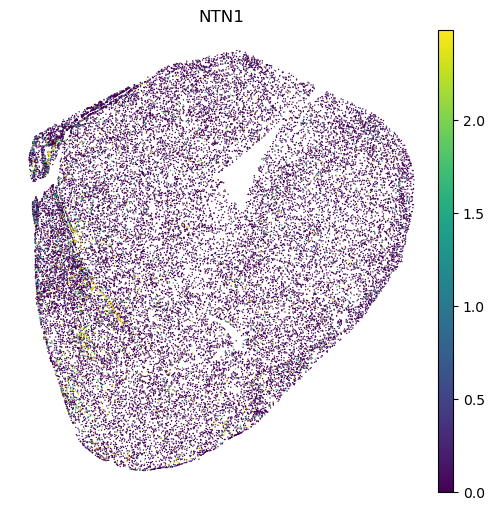

In [15]:
macaque_astro = macaque_str[
    macaque_str.obs['Group'] == 'Astrocyte'  #    #(marmoset_str.obs['Cluster'] == 'Marmoset-670') & #homologous of human-7
]

with plt.rc_context({"figure.figsize": (6, 6)}):
    sc.pl.embedding(
        macaque_astro,
        use_raw=False,
        layer='log2cpt',
        basis="spatial_grid",
        color=['NTN1'],
        frameon=False,
        ncols=1,
        vmin='p2',
        vmax='p98',
        save="NTN1_in_macaque_Astro.pdf"
    )

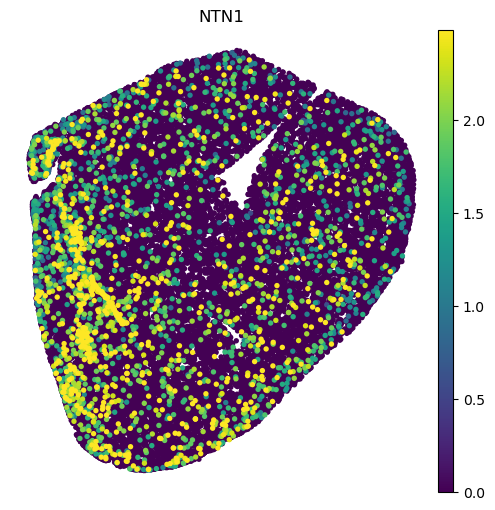

In [26]:
macaque_astro = macaque_str[
    macaque_str.obs['Group'] == 'Astrocyte'  #    #(marmoset_str.obs['Cluster'] == 'Marmoset-670') & #homologous of human-7
]

with plt.rc_context({"figure.figsize": (6, 6)}):
    sc.pl.embedding(
        macaque_astro,
        use_raw=False,
        layer='log2cpt',
        basis="spatial_grid",
        color=['NTN1'],
        frameon=False,
        ncols=1,
        vmin='p2',
        vmax='p98',
        size=60,
       # save="NTN1_in_macaque_Astro.pdf"
    )

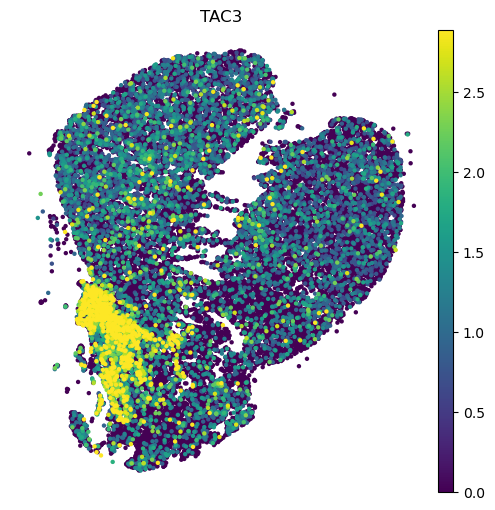

In [30]:
macaque_tac3msn = macaque_str[
    macaque_str.obs['Group'].isin(['STRv D1 MSN', 'STRd D1 Matrix MSN', 'STRd D1 Striosome MSN']) #, 'STRd D1 Matrix MSN', 'STRd D1 Matrix Striosome'
]


with plt.rc_context({"figure.figsize": (6, 6)}):
    sc.pl.embedding(
        macaque_tac3msn,
        use_raw=False,
        layer='log2cpt',
        basis="spatial_grid",
        color=['TAC3'],
        frameon=False,
        ncols=1,
        vmin='p2',
        vmax='p98',
        size=40,
        save="TAC3_in_Macaque_D1MSNsubclass.pdf"
    )

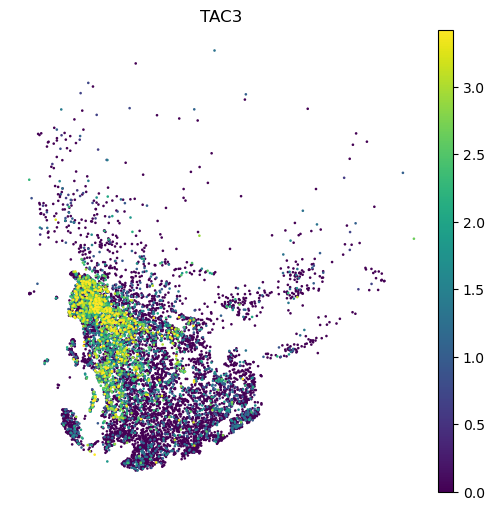

In [12]:
macaque_tac3msn = macaque_str[
    macaque_str.obs['Group'].isin(['STRv D1 MSN']) #, 'STRd D1 Matrix MSN', 'STRd D1 Matrix Striosome'
]


with plt.rc_context({"figure.figsize": (6, 6)}):
    sc.pl.embedding(
        macaque_tac3msn,
        use_raw=False,
        layer='log2cpt',
        basis="spatial_grid",
        color=['TAC3'],
        frameon=False,
        ncols=1,
        vmin='p2',
        vmax='p98',
        save="TAC3_in_Macaque_D1STRvMSN.pdf"
    )

In [16]:
macaque_str.obs['Group'] = macaque_str.obs['Group'].astype(str)

target_groups = [
    "STRd D1 Matrix MSN",
    "STRd D1 Striosome MSN",
    #"STRd D2 Matrix MSN",
   # "STRd D2 StrioMat Hybrid MSN",
   # "STRd D2 Striosome MSN",
    "STRv D1 MSN",
  #  "STRv D2 MSN",
   # "STRv D1 NUDAP MSN",
  #  "STR D1D2 Hybrid MSN",
   # "OT D1 ICj"
]

mask = macaque_str.obs['Group'].isin(target_groups)
macaque_msn = macaque_str[mask].copy()

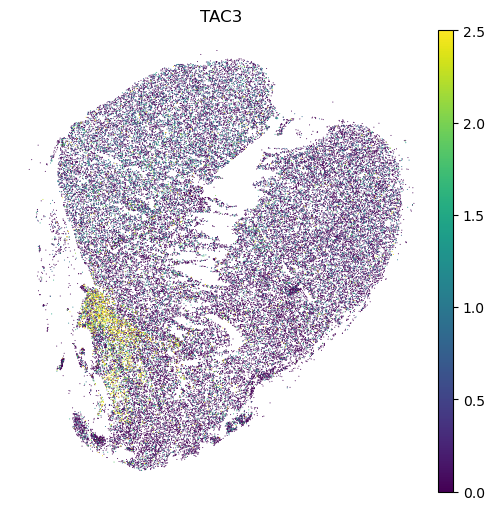

In [17]:
with plt.rc_context({"figure.figsize": (6, 6)}):
    sc.pl.embedding(
        macaque_msn,
        use_raw=False,
        layer='log2cpt',
        basis="spatial_grid",
        color=['TAC3'],
        frameon=False,
        ncols=1,
        vmin='p2',
        vmax='p98',
        save="TAC3_in_macaque_MSN.pdf"
    )

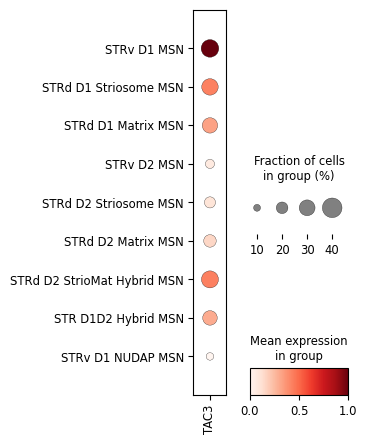

In [17]:
group_order = ['STRv D1 MSN', 'STRd D1 Striosome MSN', 'STRd D1 Matrix MSN', 'STRv D2 MSN', 'STRd D2 Striosome MSN', 'STRd D2 Matrix MSN', 'STRd D2 StrioMat Hybrid MSN', 'STR D1D2 Hybrid MSN', 'STRv D1 NUDAP MSN']
macaque_msn.obs['Group'] = pd.Categorical(macaque_msn.obs['Group'],
                                          categories=group_order,
                                          ordered=True)

sc.pl.dotplot(macaque_msn, 
              ['TAC3'], 
              groupby='Group', 
              standard_scale='var',#'var',
              use_raw=False, 
              layer='log2cpt',
              swap_axes=False, 
              figsize=(2,5),
              save="dotplot_TAC3_in_MacaqueSpatialTx_MSNs_Groups_scaled.pdf" 
) 

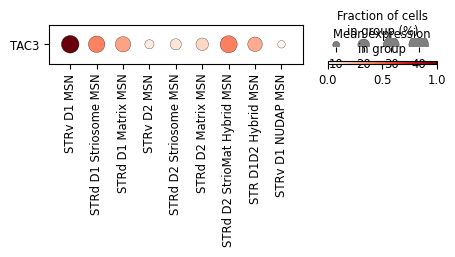

In [18]:
group_order = ['STRv D1 MSN', 'STRd D1 Striosome MSN', 'STRd D1 Matrix MSN', 'STRv D2 MSN', 'STRd D2 Striosome MSN', 'STRd D2 Matrix MSN', 'STRd D2 StrioMat Hybrid MSN', 'STR D1D2 Hybrid MSN', 'STRv D1 NUDAP MSN']
macaque_msn.obs['Group'] = pd.Categorical(macaque_msn.obs['Group'],
                                          categories=group_order,
                                          ordered=True)

sc.pl.dotplot(macaque_msn, 
              ['TAC3'], 
              groupby='Group', 
              standard_scale='var',#'var',
              use_raw=False, 
              layer='log2cpt',
              swap_axes=True, 
              figsize=(5,0.5),
              save="dotplot_TAC3_in_MacaqueSpatialTx_MSNs_Groups_scaled2.pdf" 
) 

### Human

In [33]:
human = sc.read_h5ad(root_directory + "/hmba_release_format_human_cirro_h5ad_20250624.h5ad")
human

AnnData object with n_obs × n_vars = 6992128 × 315
    obs: 'x', 'y', 'brain_section_label', 'brain_section_barcode', 'slab', 'block', 'set', 'z_order', 'total_counts', 'total_counts_genes', 'n_genes_by_counts', 'total_counts_Blank', 'pct_counts_Blank', 'genes_filter', 'counts_filter', 'blanks_filter', 'qc_pass', 'doublets_filter', 'qc_pass_and_singlet', 'doublet_singlet_score_diff', 'doublet_diff_threshold', 'hierarchy_consistent', 'Neighborhood', 'Neighborhood_bootstrapping_probability', 'Neighborhood_correlation_coefficient', 'Class', 'Class_bootstrapping_probability', 'Class_correlation_coefficient', 'Subclass', 'Subclass_bootstrapping_probability', 'Subclass_correlation_coefficient', 'Group', 'Group_bootstrapping_probability', 'Group_correlation_coefficient', 'cluster_id', 'cluster_id_bootstrapping_probability', 'cluster_id_correlation_coefficient', 'Neighborhood_entropy', 'Class_entropy', 'Subclass_entropy', 'Group_entropy', 'cluster_id_entropy', 'STAligner_mclust_res_10_knn_15',

In [37]:
selected_sections = [7] #6,7, 8

human_str = human[
    (human.obs['z_order'].isin(selected_sections)) &
    (human.obs['qc_pass'])  & 
    (human.obs['abc_atlas_release'])
    ].copy()

human_str

AnnData object with n_obs × n_vars = 354533 × 315
    obs: 'x', 'y', 'brain_section_label', 'brain_section_barcode', 'slab', 'block', 'set', 'z_order', 'total_counts', 'total_counts_genes', 'n_genes_by_counts', 'total_counts_Blank', 'pct_counts_Blank', 'genes_filter', 'counts_filter', 'blanks_filter', 'qc_pass', 'doublets_filter', 'qc_pass_and_singlet', 'doublet_singlet_score_diff', 'doublet_diff_threshold', 'hierarchy_consistent', 'Neighborhood', 'Neighborhood_bootstrapping_probability', 'Neighborhood_correlation_coefficient', 'Class', 'Class_bootstrapping_probability', 'Class_correlation_coefficient', 'Subclass', 'Subclass_bootstrapping_probability', 'Subclass_correlation_coefficient', 'Group', 'Group_bootstrapping_probability', 'Group_correlation_coefficient', 'cluster_id', 'cluster_id_bootstrapping_probability', 'cluster_id_correlation_coefficient', 'Neighborhood_entropy', 'Class_entropy', 'Subclass_entropy', 'Group_entropy', 'cluster_id_entropy', 'STAligner_mclust_res_10_knn_15', 

/home/yuanyuan.fu/bin/miniconda3/envs/iterative_scANVI_May9/lib/python3.11/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


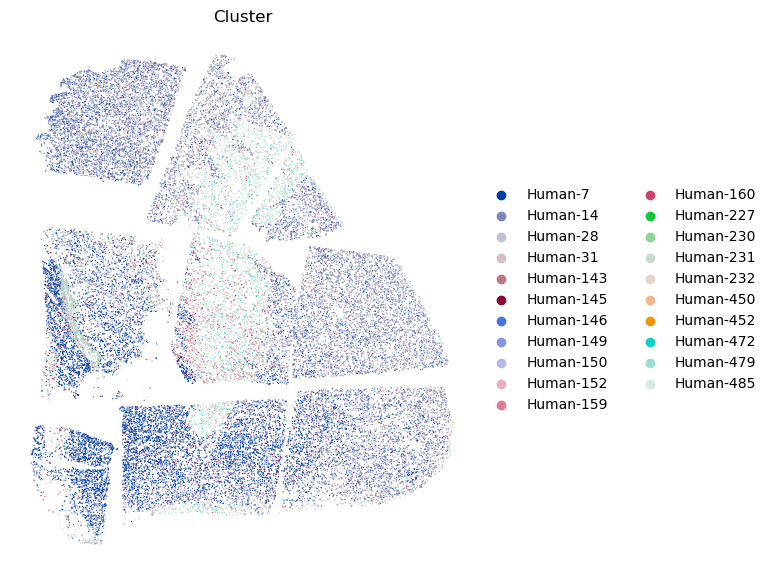

In [38]:
human_astro = human_str[
    human_str.obs['Group'] == 'Astrocyte'  #    #(marmoset_str.obs['Cluster'] == 'Marmoset-670') & #homologous of human-7
]

with plt.rc_context({"figure.figsize": (6, 7)}):
    sc.pl.embedding(
        human_astro,
        use_raw=False,
        layer='log2cpt',
        basis="spatial_grid",
        color=['Cluster'],
        frameon=False,
        ncols=1,
       # save="NTN1_in_macaque_Astro.pdf"
    )

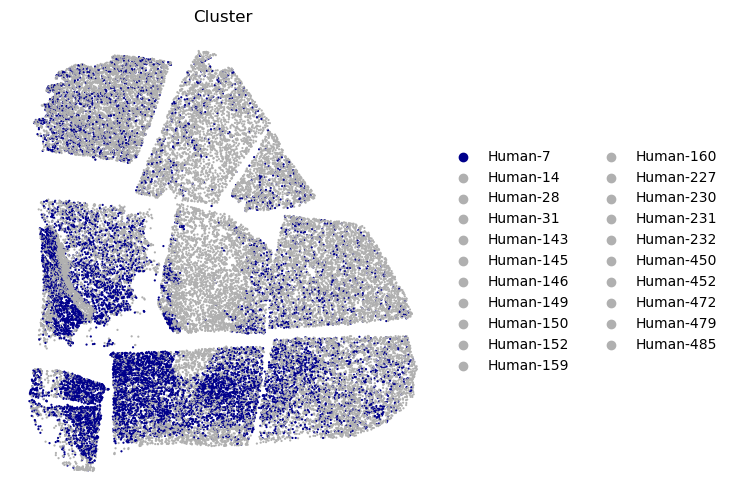

In [40]:

human_astro.obs['Cluster'] = human_astro.obs['Cluster'].cat.remove_unused_categories()

cats = human_astro.obs['Cluster'].cat.categories
cats_list = list(cats)


palette = np.full(len(cats_list), '#B0B0B0', dtype=object)  # '#C0C0C0'


try:
    idx_7 = cats_list.index('Human-7')
    palette[idx_7] = '#00008B' 
except ValueError:
    print("⚠️ 'Human-7' not in categories：", cats_list)


human_astro.uns['Cluster_colors'] = palette.tolist()

with plt.rc_context({"figure.figsize": (5.5, 6)}):
    sc.pl.embedding(
        human_astro,
        use_raw=False,
        layer='raw',
        basis="spatial_grid",
        color=['Cluster'],
        frameon=False,
        ncols=1,
        size=10,
        save="Clusters_in_human_astro-7_blue.pdf"
    )


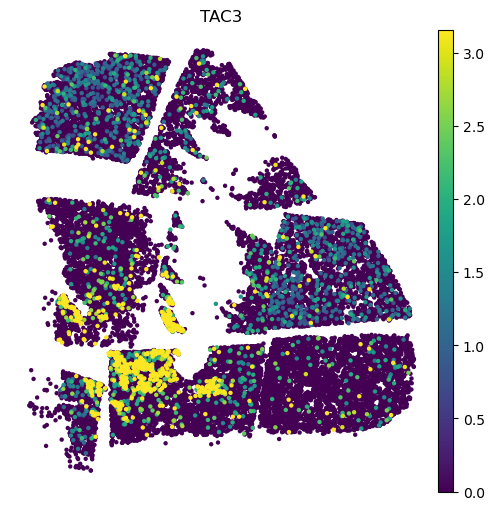

In [45]:
human_tac3msn = human_str[
    human_str.obs['Group'].isin(['STRv D1 MSN', 'STRd D1 Matrix MSN', 'STRd D1 Striosome MSN']) #
]


with plt.rc_context({"figure.figsize": (6, 6)}):
    sc.pl.embedding(
        human_tac3msn,
        use_raw=False,
        layer='log2cpt',
        basis="spatial_grid",
        color=['TAC3'],
        frameon=False,
        ncols=1,
        vmin='p2',
        vmax='p98',
        size=40,
        save="TAC3_in_human_D1MSNsubclass.pdf"
    )

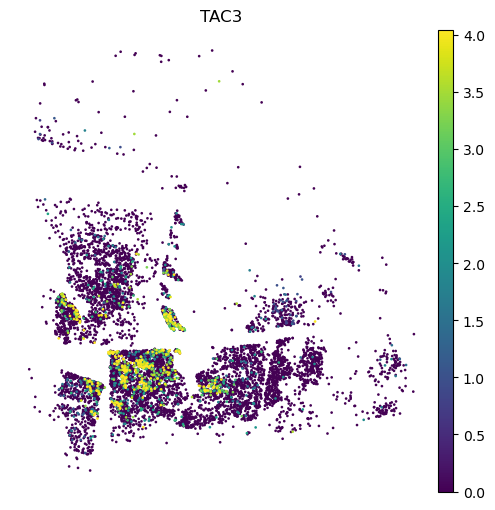

In [22]:
human_tac3msn = human_str[
    human_str.obs['Group'].isin(['STRv D1 MSN']) #, 'STRd D1 Matrix MSN', 'STRd D1 Matrix Striosome'
]


with plt.rc_context({"figure.figsize": (6, 6)}):
    sc.pl.embedding(
        human_tac3msn,
        use_raw=False,
        layer='log2cpt',
        basis="spatial_grid",
        color=['TAC3'],
        frameon=False,
        ncols=1,
        vmin='p2',
        vmax='p98',
        save="TAC3_in_human_D1STRvMSN.pdf"
    )

In [22]:
human_str.obs['Group'] = human_str.obs['Group'].astype(str)

target_groups = [
    "STRd D1 Matrix MSN",
    "STRd D1 Striosome MSN",
    "STRd D2 Matrix MSN",
    "STRd D2 StrioMat Hybrid MSN",
    "STRd D2 Striosome MSN",
    "STRv D1 MSN",
    "STRv D2 MSN",
    "STRv D1 NUDAP MSN",
    "STR D1D2 Hybrid MSN",
   # "OT D1 ICj"
]

mask = human_str.obs['Group'].isin(target_groups)
human_msn = human_str[mask].copy()

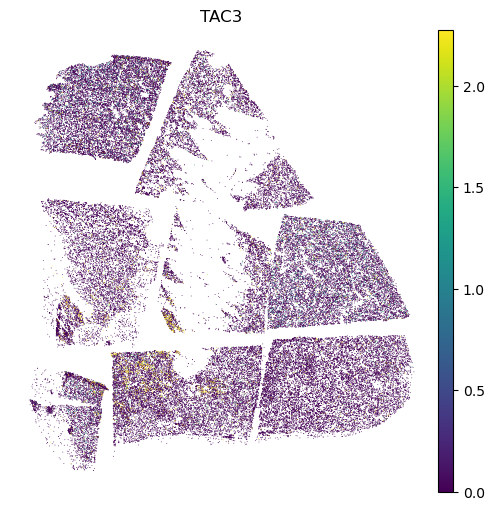

In [244]:
with plt.rc_context({"figure.figsize": (6, 6)}):
    sc.pl.embedding(
        human_msn,
        use_raw=False,
        layer='log2cpt',
        basis="spatial_grid",
        color=['TAC3'],
        frameon=False,
        ncols=1,
        vmin='p2',
        vmax='p98',
        save="TAC3_in_human_MSN.pdf"
    )

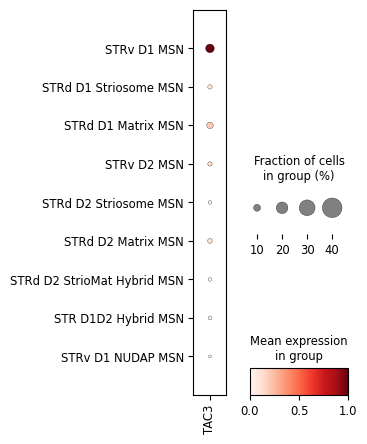

In [27]:
group_order = ['STRv D1 MSN', 'STRd D1 Striosome MSN', 'STRd D1 Matrix MSN', 'STRv D2 MSN', 'STRd D2 Striosome MSN', 'STRd D2 Matrix MSN', 'STRd D2 StrioMat Hybrid MSN', 'STR D1D2 Hybrid MSN', 'STRv D1 NUDAP MSN']
human_msn.obs['Group'] = pd.Categorical(human_msn.obs['Group'],
                                          categories=group_order,
                                          ordered=True)

sc.pl.dotplot(human_msn, 
              ['TAC3'], 
              groupby='Group', 
              standard_scale='var',#'var',
              use_raw=False, 
              layer='log2cpt',
              swap_axes=False, 
              figsize=(2,5),
              dot_max=0.4,
              save="dotplot_TAC3_in_HumanSpatialTx_MSNs_Groups_scaled.pdf" 
) 

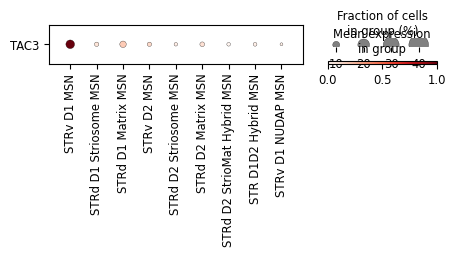

In [23]:
group_order = ['STRv D1 MSN', 'STRd D1 Striosome MSN', 'STRd D1 Matrix MSN', 'STRv D2 MSN', 'STRd D2 Striosome MSN', 'STRd D2 Matrix MSN', 'STRd D2 StrioMat Hybrid MSN', 'STR D1D2 Hybrid MSN', 'STRv D1 NUDAP MSN']
human_msn.obs['Group'] = pd.Categorical(human_msn.obs['Group'],
                                          categories=group_order,
                                          ordered=True)

sc.pl.dotplot(human_msn, 
              ['TAC3'], 
              groupby='Group', 
              standard_scale='var',#'var',
              use_raw=False, 
              layer='log2cpt',
              swap_axes=True, 
              figsize=(5,0.5),
              dot_max=0.4,
              save="dotplot_TAC3_in_HumanSpatialTx_MSNs_Groups_scaled2.pdf" 
) 

In [ ]:
adata_human_astro = adata_human[
    (adata_human.obs['Group'] == 'Astrocyte') &
    (adata_human.obs['qc_pass']) # & (adata_human.obs['abc_atlas_release']) # to keep adjacent regions    
].copy()



In [ ]:

selected_sections = [6, 7, 8, 9, 10]
adata_human_astro = adata_human_astro[adata_human_astro.obs['z_order'].isin(selected_sections)].copy()
adata_human_astro

### across species clusters-homologous

In [2]:
adata = sc.read_h5ad("/allen/programs/celltypes/workgroups/rnaseqanalysis/hct_ux3_cellxgene/anndata_080/BasalGanglia/xspecies//HMBA_Human_Macaque_Marmoset_Mouse_snRNA-seq_BG_alignment_non-neurons.h5ad")
adata

AnnData object with n_obs × n_vars = 957339 × 3000
    obs: 'Neighborhood', 'Class', 'Subclass', 'Group', 'Cluster', 'cluster_id', 'cell_type_ontology_term', 'load_id', 'donor_id', 'assay', 'assay_ontology_term_id', 'organism', 'organism_ontology_term_id', 'development_stage', 'anatomical_region', 'anatomical_region_merged', 'anatomical_region_ontology_term_id', 'brain_region_ontology_term_id', 'self_reported_sex', 'self_reported_sex_ontology_term_id', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'disease', 'disease_ontology_term_id', 'suspension_type', 'is_primary_data', 'total_counts', 'total_genes', 'doublet_score', 'organism_sci', 'accession_group', 'embedding_set', 'CL:ID_group', 'tokens_group', 'display_order_group', 'literature_support', 'literature_name_short', 'literature_name_long', 'curated_markers', 'color_hex_group', 'color_group', 'accession_subclass', 'CL:ID_subclass', 'tokens_subclass', 'display_order_subclass', 'color_hex_subclass', 'color_sub

In [3]:
adata_astro = adata[adata.obs['Group'] == 'Astrocyte']

In [4]:
adata_astro

View of AnnData object with n_obs × n_vars = 202762 × 3000
    obs: 'Neighborhood', 'Class', 'Subclass', 'Group', 'Cluster', 'cluster_id', 'cell_type_ontology_term', 'load_id', 'donor_id', 'assay', 'assay_ontology_term_id', 'organism', 'organism_ontology_term_id', 'development_stage', 'anatomical_region', 'anatomical_region_merged', 'anatomical_region_ontology_term_id', 'brain_region_ontology_term_id', 'self_reported_sex', 'self_reported_sex_ontology_term_id', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'disease', 'disease_ontology_term_id', 'suspension_type', 'is_primary_data', 'total_counts', 'total_genes', 'doublet_score', 'organism_sci', 'accession_group', 'embedding_set', 'CL:ID_group', 'tokens_group', 'display_order_group', 'literature_support', 'literature_name_short', 'literature_name_long', 'curated_markers', 'color_hex_group', 'color_group', 'accession_subclass', 'CL:ID_subclass', 'tokens_subclass', 'display_order_subclass', 'color_hex_subclass', 'c

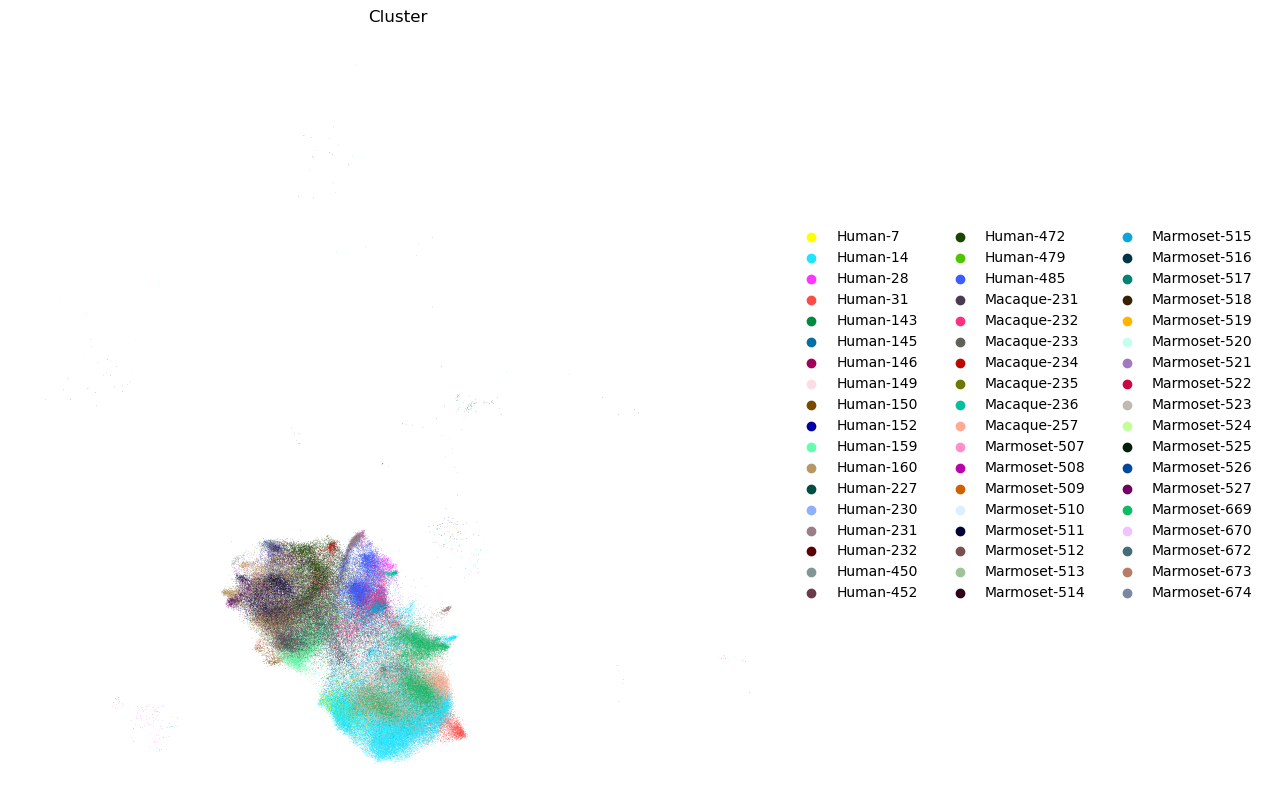

In [8]:
with plt.rc_context({"figure.figsize": (10, 10)}):
    sc.pl.embedding(
        adata_astro,
        use_raw=False,
        basis="X_umap",
        color=['Cluster'],
        frameon=False,
        ncols=1,
    )



/scratch/fast/3105978/ipykernel_2658324/3993285552.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_b = plt.cm.get_cmap("tab20b")
/scratch/fast/3105978/ipykernel_2658324/3993285552.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_c = plt.cm.get_cmap("tab20c")


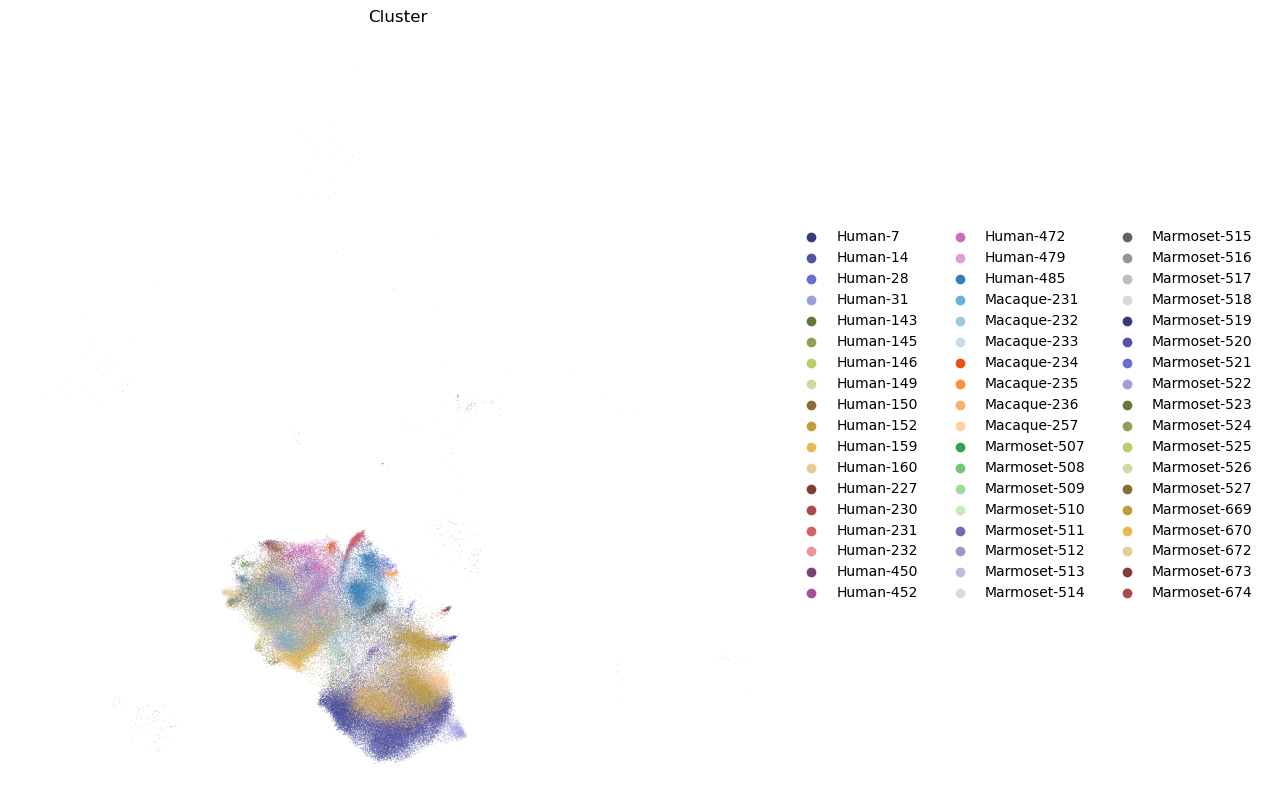

In [9]:
def get_tab20bc_palette():
    """
    Combine tab20b and tab20c into a 40-color palette
    (8 families × 5 colors each).
    """
    cmap_b = plt.cm.get_cmap("tab20b")
    cmap_c = plt.cm.get_cmap("tab20c")

    colors_b = [cmap_b(i) for i in range(cmap_b.N)]  # 20 colors
    colors_c = [cmap_c(i) for i in range(cmap_c.N)]  # 20 colors

    return colors_b + colors_c   # 40 colors total

# get color palette
colors = get_tab20bc_palette()


with plt.rc_context({"figure.figsize": (10, 10)}):
    sc.pl.embedding(
        adata_astro,
        use_raw=False,
        basis="X_umap",
        color=['Cluster'],
        frameon=False,
        ncols=1,
        palette=colors
    )
